## Introduccion

En este notebook resolvemos el problema lineal (LP) de calcular la funcion de soporte de un zonotope.

## Preparando la entrada

In [1]:
using LazySets, Plots

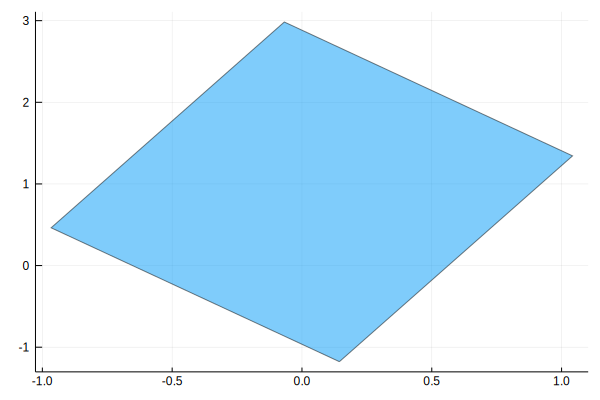

In [7]:
Z = rand(Zonotope, dim=2)
plot(Z)

In [8]:
dump(Z)

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}
  center: Array{Float64}((2,)) [0.037992513923933956, 0.9031345470900635]
  generators: Array{Float64}((2, 2)) [0.5551582017905393 -0.44909462556735547; -0.8199623017483215 -1.2605193205033978]


In [9]:
A, b = tosimplehrep(Z)

([-0.8280594027471305 -0.5606403709349386; 0.8280594027471305 0.5606403709349386; -0.9419998425830272 0.335613314058832; 0.9419998425830272 -0.335613314058832], [0.5407813009684864, 1.6163687927153778, 1.0654642404426657, 0.5308341679341875])

In [10]:
HPolytope(A, b) # Ax <= b

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-0.8280594027471305, -0.5606403709349386], 0.5407813009684864), HalfSpace{Float64,Array{Float64,1}}([0.8280594027471305, 0.5606403709349386], 1.6163687927153778), HalfSpace{Float64,Array{Float64,1}}([-0.9419998425830272, 0.335613314058832], 1.0654642404426657), HalfSpace{Float64,Array{Float64,1}}([0.9419998425830272, -0.335613314058832], 0.5308341679341875)])

In [12]:
A

4×2 Array{Float64,2}:
 -0.828059  -0.56064
  0.828059   0.56064
 -0.942      0.335613
  0.942     -0.335613

In [13]:
b

4-element Array{Float64,1}:
 0.5407813009684864
 1.6163687927153778
 1.0654642404426657
 0.5308341679341875

In [14]:
using BenchmarkTools

In [16]:
@btime tosimplehrep($Z)

  3.276 μs (98 allocations: 6.89 KiB)


([-0.8280594027471305 -0.5606403709349386; 0.8280594027471305 0.5606403709349386; -0.9419998425830272 0.335613314058832; 0.9419998425830272 -0.335613314058832], [0.5407813009684864, 1.6163687927153778, 1.0654642404426657, 0.5308341679341875])

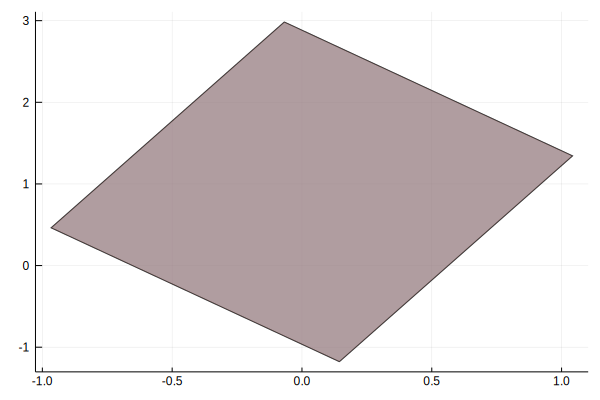

In [11]:
plot!(ans)

## Formulacion en JuMP

Usamos  `[4076af6c] JuMP v0.20.1`, ver http://www.juliaopt.org/JuMP.jl/v0.20/quickstart/

In [22]:
using JuMP,  GLPK

In [27]:
] st JuMP

Status `~/.julia/environments/v1.4/Project.toml`
  [4076af6c] JuMP v0.20.1


In [28]:
model = Model(with_optimizer(GLPK.Optimizer))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [30]:
@variable(model, x[1:2])

2-element Array{VariableRef,1}:
 x[1]
 x[2]

In [39]:
x[1] + x[2]

x[1] + x[2]

In [40]:
typeof(ans)

GenericAffExpr{Float64,VariableRef}

In [41]:
@constraint(model, A*x .<= b)

4-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 -0.8280594027471305 x[1] - 0.5606403709349386 x[2] ≤ 0.5407813009684864
 0.8280594027471305 x[1] + 0.5606403709349386 x[2] ≤ 1.6163687927153778
 -0.9419998425830272 x[1] + 0.335613314058832 x[2] ≤ 1.0654642404426657
 0.9419998425830272 x[1] - 0.335613314058832 x[2] ≤ 0.5308341679341875

In [42]:
model

A JuMP Model
Feasibility problem with:
Variables: 2
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: x

In [43]:
b

4-element Array{Float64,1}:
 0.5407813009684864
 1.6163687927153778
 1.0654642404426657
 0.5308341679341875

In [44]:
d = [1.0, 1.0]

2-element Array{Float64,1}:
 1.0
 1.0

In [48]:
@objective(model, Min, d[1]*x[1] + d[2]*x[2])

x[1] + x[2]

O de forma mas generica,

In [46]:
using LinearAlgebra

In [58]:
@objective(model, Max, dot(d, x))

x[1] + x[2]

In [59]:
model

A JuMP Model
Maximization problem with:
Variables: 2
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: GLPK
Names registered in the model: x

In [61]:
@time optimize!(model) # resolver

  0.000020 seconds (2 allocations: 32 bytes)


In [62]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [63]:
if termination_status(model) == MOI.OPTIMAL
    optimal_solution = value.(x)
    optimal_objective = objective_value(model)
elseif termination_status(model) == MOI.TIME_LIMIT && has_values(model)
    suboptimal_solution = value.(x)
    suboptimal_objective = objective_value(model)
else
    error("The model was not solved correctly.")
end

2.9155451070425324

In [64]:
value(x[1])

-0.06807106229924985

In [65]:
value(x[2])

2.9836161693417824

In [66]:
value.(x)

2-element Array{Float64,1}:
 -0.06807106229924985
  2.9836161693417824

Vector de soporte:

In [67]:
value.(x)

2-element Array{Float64,1}:
 -0.06807106229924985
  2.9836161693417824

Funcion de soporte:

In [68]:
objective_value(model)

2.9155451070425324

### Pasando en limpio:

In [76]:
function funcion_de_soporte(d, A, b)
    @assert length(d) == size(A, 2)
    n = length(d)
    model = Model(with_optimizer(GLPK.Optimizer))
    @variable(model, x[1:n])
    @constraint(model, A*x .<= b)
    @objective(model, Max, dot(d, x))
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        supfunc = objective_value(model)
        supvect = value.(x)
    else
        error("the termination status is $(termination_status(model))")
    end
    return supfunc, supvect
end

function funcion_de_soporte(d, Z::Zonotope)
    A, b = tosimplehrep(Z)
    funcion_de_soporte(d, A, b)
end

funcion_de_soporte (generic function with 2 methods)

In [75]:
@btime funcion_de_soporte($d, $A, $b)

  166.850 μs (1231 allocations: 93.23 KiB)


(2.915545107042533, [-0.0680710622992498, 2.983616169341783])

In [77]:
@btime funcion_de_soporte($d, $Z)

  177.378 μs (1328 allocations: 100.09 KiB)


(2.915545107042533, [-0.0680710622992498, 2.983616169341783])

In [78]:
d5  = rand(5)
Z5 = rand(Zonotope, dim=5)

A5, b5 = tosimplehrep(Z5)
@btime funcion_de_soporte($d5, $A5, $b5)
@btime funcion_de_soporte($d5, $Z5)

  205.751 μs (1629 allocations: 116.56 KiB)
  236.741 μs (2057 allocations: 149.75 KiB)


(6.3844288875594195, [0.9450399512066295, -1.1219395584827097, 6.107215771033748, -0.6279268687353181, 2.758243781852051])

## Comparacion con LazySets

In [79]:
ρ(d, Z) # funcion de soporte

2.915545107042533

In [80]:
σ(d, Z) # vector de soporte

2-element Array{Float64,1}:
 -0.06807106229924989
  2.983616169341783

In [81]:
@btime ρ($d, $Z)

  96.119 ns (2 allocations: 192 bytes)


2.915545107042533

In [82]:
@btime σ($d, $Z)

  160.505 ns (4 allocations: 384 bytes)


2-element Array{Float64,1}:
 -0.06807106229924989
  2.983616169341783

In [84]:
177e-6 / ((96 + 160)*1e-9)

691.4062499999999

In [85]:
@btime ρ($d5, $Z5) # funcion de soporte
@btime σ($d5, $Z5) # vector de soporte

  119.794 ns (2 allocations: 256 bytes)
  205.193 ns (4 allocations: 512 bytes)


5-element Array{Float64,1}:
  0.9450399512066299
 -1.1219395584827097
  6.107215771033748
 -0.6279268687353178
  2.7582437818520487

## Caso especial de poligonos

In [88]:
H = HPolygon(A, b);

@btime ρ($d, $H)

  460.645 ns (12 allocations: 688 bytes)


2.915545107042533

---